In [3]:
"""
SARIMAX Model Evaluation Notebook

This notebook:
1. Randomly selects 2 companies from the data folder
2. Loads and prepares the data (calculates returns)
3. Fits SARIMAX models with optimal parameter selection (p, d, q, P, D, Q)
4. Visualizes predictions vs actual values
"""

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple, Dict
import sys
import warnings
warnings.filterwarnings('ignore')

current_dir = Path.cwd()
if current_dir.name == 'evaluation':
    project_root = current_dir.parent
else:
    # If running from project root, use current directory
    project_root = current_dir

sys.path.insert(0, str(project_root))

# Import forecast functions
from src.forecast import (
    arima_forecast,
    sarima_forecast,
    sarimax_forecast,
    prophet_forecast,
    lstm_forecast,
    tcn_forecast,
    transformer_forecast
)

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

print("✓ Imports successful!")
print("✓ SARIMAX forecast function imported")

✓ Imports successful!
✓ SARIMAX forecast function imported


## Step 1: Load Data and Select 2 Random Companies


In [5]:
# Define data directory
project_root = Path.cwd().parent if Path.cwd().name == 'evaluation' else Path.cwd()
data_dir = project_root / 'data'

# Get all CSV files (excluding cache directory)
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# Randomly select 2 companies
num_companies = 2
selected_companies = random.sample(csv_files, num_companies)

print(f"Selected {num_companies} companies: {[f.split('_')[0] for f in selected_companies]}")
print(f"Total files available: {len(csv_files)}\n")

def load_company_data(filepath: Path) -> Tuple[str, pd.Series]:
    """
    Load company data from CSV file.
    
    The CSV structure is:
    - Row 1: Column names (Price, Close, High, Low, Open, Volume)
    - Row 2: Ticker metadata
    - Row 3: Date header row
    - Row 4+: Actual data with dates in first column
    
    Args:
        filepath: Path to the CSV file
        
    Returns:
        Tuple of (ticker, Series with Date index and Close prices)
    """
    # Read CSV with header from first row, skip rows 2 and 3 (ticker and Date header)
    df = pd.read_csv(filepath, header=0, skiprows=[1, 2])
    
    # Extract ticker from filename
    ticker = filepath.stem.split('_')[0]
    
    # The first column should be 'Price' which contains the dates
    # Rename it to 'Date' for clarity
    if 'Price' in df.columns:
        df = df.rename(columns={'Price': 'Date'})
    
    # Convert Date column to datetime and set as index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Use Close price column
    if 'Close' not in df.columns:
        raise ValueError(f"Close column not found. Available columns: {df.columns.tolist()}")
    
    close_prices = df['Close'].copy()
    
    return ticker, close_prices

# Load data for selected companies
company_data = {}
for filename in selected_companies:
    filepath = data_dir / filename
    ticker, prices = load_company_data(filepath)
    company_data[ticker] = prices
    print(f"\n{ticker}:")
    print(f"  Data points: {len(prices)}")
    print(f"  Date range: {prices.index[0]} to {prices.index[-1]}")
    print(f"  Price range: ${prices.min():.2f} - ${prices.max():.2f}")


Selected 2 companies: ['XLK', 'NKE']
Total files available: 29


XLK:
  Data points: 2512
  Date range: 2015-11-27 00:00:00 to 2025-11-21 00:00:00
  Price range: $34.66 - $304.13

NKE:
  Data points: 2512
  Date range: 2015-11-27 00:00:00 to 2025-11-21 00:00:00
  Price range: $44.32 - $167.31


## Step 2: Calculate Returns and Split Data


In [6]:
# Calculate returns for each company
# Returns = (Price_t - Price_{t-1}) / Price_{t-1}
returns_data = {}
for ticker, prices in company_data.items():
    returns = prices.pct_change().dropna()
    returns_data[ticker] = returns
    print(f"\n{ticker} Returns:")
    print(f"  Data points: {len(returns)}")
    print(f"  Mean return: {returns.mean():.6f}")
    print(f"  Std return: {returns.std():.6f}")
    print(f"  Min return: {returns.min():.6f}")
    print(f"  Max return: {returns.max():.6f}")

# Split data into train and test sets
# Use 80% for training, 20% for testing
train_test_split = {}
forecast_horizon = 30  # Forecast 30 days ahead

for ticker, returns in returns_data.items():
    # Reserve last forecast_horizon days for testing
    split_idx = len(returns) - forecast_horizon
    train_returns = returns.iloc[:split_idx]
    test_returns = returns.iloc[split_idx:]
    
    train_test_split[ticker] = {
        'train': train_returns,
        'test': test_returns
    }
    
    print(f"\n{ticker} Split:")
    print(f"  Train: {len(train_returns)} points ({train_returns.index[0]} to {train_returns.index[-1]})")
    print(f"  Test: {len(test_returns)} points ({test_returns.index[0]} to {test_returns.index[-1]})")



XLK Returns:
  Data points: 2511
  Mean return: 0.000891
  Std return: 0.015279
  Min return: -0.138140
  Max return: 0.134257

NKE Returns:
  Data points: 2511
  Mean return: 0.000220
  Std return: 0.019837
  Min return: -0.199809
  Max return: 0.155315

XLK Split:
  Train: 2481 points (2015-11-30 00:00:00 to 2025-10-10 00:00:00)
  Test: 30 points (2025-10-13 00:00:00 to 2025-11-21 00:00:00)

NKE Split:
  Train: 2481 points (2015-11-30 00:00:00 to 2025-10-10 00:00:00)
  Test: 30 points (2025-10-13 00:00:00 to 2025-11-21 00:00:00)


## Step 3: Parameter Optimization Function

We'll create a function to find optimal SARIMAX parameters (p, d, q, P, D, Q) using grid search with BIC criterion.


In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf

def find_optimal_sarimax_params(
    series: pd.Series,
    exog: pd.DataFrame = None,
    max_p: int = 3,
    max_d: int = 2,
    max_q: int = 3,
    max_P: int = 2,
    max_D: int = 1,
    max_Q: int = 2,
    seasonal_period: int = 5,
    verbose: bool = True
) -> Tuple[Tuple[int, int, int], Tuple[int, int, int, int]]:
    """
    Find optimal SARIMAX parameters using grid search with BIC criterion.
    
    Args:
        series: Time series data
        exog: Exogenous variables (optional)
        max_p, max_d, max_q: Maximum values for non-seasonal ARIMA parameters
        max_P, max_D, max_Q: Maximum values for seasonal ARIMA parameters
        seasonal_period: Seasonal period (s)
        verbose: Whether to print progress
    
    Returns:
        Tuple of ((p, d, q), (P, D, Q, s)) - optimal parameters
    """
    best_bic = np.inf
    best_order = None
    best_seasonal_order = None
    best_forecast_std = 0
    
    # Use ADF test to suggest differencing
    adf_pvalue = adfuller(series)[1]
    suggested_d = 0 if adf_pvalue < 0.05 else 1
    
    # For returns, prefer d=0 (returns are usually stationary)
    if np.abs(series.mean()) < 0.001 and series.std() > 0:
        suggested_d = 0
    
    # Limit search space to reasonable values
    d_range = [0, 1] if suggested_d == 0 else [0, 1, 2]
    D_range = [0, 1]
    
    total_combinations = (max_p + 1) * len(d_range) * (max_q + 1) * (max_P + 1) * len(D_range) * (max_Q + 1)
    if verbose:
        print(f"Searching {total_combinations} parameter combinations...")
        print(f"Suggested differencing: d={suggested_d}")
    
    count = 0
    for p in range(max_p + 1):
        for d in d_range:
            for q in range(max_q + 1):
                # Skip (0, d, 0) as it produces flat forecasts
                if p == 0 and q == 0:
                    continue
                    
                for P in range(max_P + 1):
                    for D in D_range:
                        for Q in range(max_Q + 1):
                            # Skip (0, D, 0) seasonal as it may produce flat forecasts
                            if P == 0 and Q == 0:
                                continue
                            
                            count += 1
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, seasonal_period)
                            
                            try:
                                model = SARIMAX(
                                    series,
                                    exog=exog,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    trend='c',  # Add constant term for dynamics
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                )
                                
                                # Fit model with limited iterations for speed
                                fitted = model.fit(
                                    method_kwargs={"warn_convergence": False, "maxiter": 50},
                                    disp=False
                                )
                                
                                # Check if BIC is valid and better
                                if np.isfinite(fitted.bic) and fitted.bic < best_bic:
                                    # Check forecast variance to avoid flat forecasts
                                    try:
                                        test_forecast = fitted.get_forecast(steps=min(10, len(series) // 10))
                                        forecast_std = test_forecast.predicted_mean.std()
                                        
                                        # Prefer models with some forecast variance
                                        if forecast_std > 1e-6 or best_forecast_std == 0:
                                            best_bic = fitted.bic
                                            best_order = order
                                            best_seasonal_order = seasonal_order
                                            best_forecast_std = forecast_std
                                            
                                            if verbose and count % 50 == 0:
                                                print(f"  Progress: {count}/{total_combinations} | Best BIC: {best_bic:.2f} | Order: {best_order} | Seasonal: {best_seasonal_order}")
                                    except:
                                        # If forecast check fails, still use BIC
                                        if best_forecast_std == 0:
                                            best_bic = fitted.bic
                                            best_order = order
                                            best_seasonal_order = seasonal_order
                                            
                            except Exception:
                                continue
    
    if best_order is None:
        # Fallback to default values
        best_order = (1, 0, 1)
        best_seasonal_order = (1, 0, 1, seasonal_period)
        if verbose:
            print("Warning: Could not find optimal parameters, using defaults")
    
    if verbose:
        print(f"\n✓ Optimal parameters found:")
        print(f"  Order (p, d, q): {best_order}")
        print(f"  Seasonal Order (P, D, Q, s): {best_seasonal_order}")
        print(f"  BIC: {best_bic:.2f}")
        print(f"  Forecast std: {best_forecast_std:.6f}")
    
    return best_order, best_seasonal_order

print("✓ Parameter optimization function defined")


✓ Parameter optimization function defined


## Step 4: Fit SARIMAX Models with Optimal Parameters



Processing XLK


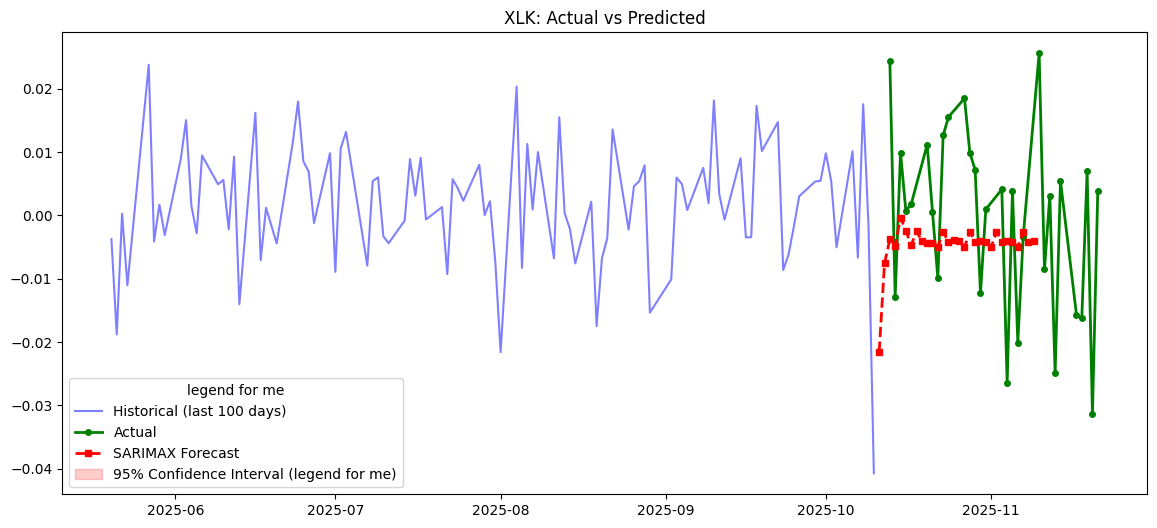


✓ XLK completed!
  MAE: 0.011576
  RMSE: 0.013628
  MAPE: 201.82%

Processing NKE


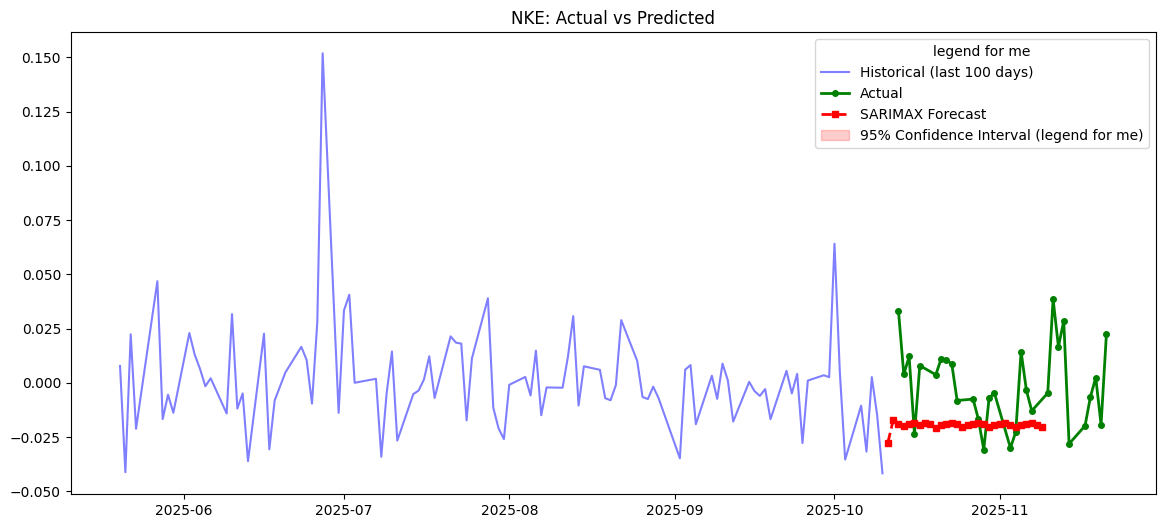


✓ NKE completed!
  MAE: 0.019194
  RMSE: 0.022942
  MAPE: 227.01%


In [ ]:
p = 1
d = 1
q = 1
results = {}

import matplotlib.pyplot as plt

for ticker, data in train_test_split.items():
    print(f"\n{'='*60}")
    print(f"Processing {ticker}")
    print(f"{'='*60}")

    train_series = data['train']
    test_series = data['test']

    try:
        # Use ARIMA (no seasonality)
        forecast, conf_int = arima_forecast(
            train_series,
            forecast_horizon=forecast_horizon,
            order=(p, d, q),
            seasonal_order=None,
            auto_select=False
        )
        actual = test_series.iloc[:len(forecast)]

        # Calculate metrics
        mae = np.mean(np.abs(actual - forecast))
        rmse = np.sqrt(np.mean((actual - forecast) ** 2))
        mape = np.mean(np.abs((actual - forecast) / (actual + 1e-8))) * 100

        results[ticker] = {
            'order': (p, d, q),
            'seasonal_order': None,
            'forecast': forecast,
            'actual': actual,
            'conf_int': conf_int,
            'mae': mae,
            'rmse': rmse,
            'mape': mape
        }

        # --- Visualization ---
        plt.figure(figsize=(14, 6))
        plt.plot(train_series.index[-100:], train_series.values[-100:], 'b-', alpha=0.5, label='Historical (last 100 days)')
        plt.plot(actual.index, actual.values, 'g-', label='Actual', linewidth=2, marker='o', markersize=4)
        plt.plot(forecast.index, forecast.values, 'r--', label='ARIMA Forecast', linewidth=2, marker='s', markersize=4)

        # --- Safe handling for conf_int and add labels for legend-for-me clarity ---
        conf_label = '95% Confidence Interval (legend for me)'
        filled = False
        if conf_int is not None and not conf_int.empty:
            # Accept columns named [lower, upper] or [lower y, upper y], fallback to any two numeric columns
            lower_col = None
            upper_col = None
            for c in conf_int.columns:
                lower_test = c.lower()
                if 'lower' in lower_test or 'lo' in lower_test:
                    lower_col = c
                if 'upper' in lower_test or 'up' in lower_test:
                    upper_col = c
            if lower_col and upper_col:
                plt.fill_between(
                    conf_int.index,
                    conf_int[lower_col],
                    conf_int[upper_col],
                    alpha=0.2,
                    color='red',
                    label=conf_label
                )
                filled = True
            else:
                # Try fallback: use first and second columns if they are numeric
                if len(conf_int.columns) >= 2:
                    c1, c2 = conf_int.columns[:2]
                    try:
                        plt.fill_between(
                            conf_int.index,
                            conf_int[c1],
                            conf_int[c2],
                            alpha=0.2,
                            color='red',
                            label=conf_label
                        )
                        filled = True
                    except Exception:
                        pass
        if not filled:
            # If no confidence interval is filled, add link in legend
            plt.plot([], [], ' ', label="No confidence interval available")
        
        plt.title(f"{ticker}: Actual vs Predicted")
        plt.legend(title="legend for me")
        plt.show()

        print(f"\n✓ {ticker} completed!")
        print(f"  MAE: {mae:.6f}")
        print(f"  RMSE: {rmse:.6f}")
        print(f"  MAPE: {mape:.2f}%")

    except Exception as e:
        print(f"✗ Error fitting {ticker}: {str(e)}")
        results[ticker] = None


## Step 5: Visualize Predictions vs Actual Values


In [ ]:
# Create visualization for each company
fig, axes = plt.subplots(len(results), 1, figsize=(14, 6 * len(results)))
if len(results) == 1:
    axes = [axes]

for idx, (ticker, result) in enumerate(results.items()):
    if result is None:
        continue
    
    ax = axes[idx]
    
    # Get data
    forecast = result['forecast']
    actual = result['actual']
    conf_int = result['conf_int']
    
    # Plot historical training data (last 100 points for context)
    train_returns = train_test_split[ticker]['train']
    historical = train_returns.iloc[-100:]
    ax.plot(historical.index, historical.values, 'b-', alpha=0.5, label='Historical (last 100 days)', linewidth=1)
    
    # Plot actual test values
    ax.plot(actual.index, actual.values, 'g-', label='Actual', linewidth=2, marker='o', markersize=4)
    
    # Plot forecast
    ax.plot(forecast.index, forecast.values, 'r--', label='SARIMAX Forecast', linewidth=2, marker='s', markersize=4)
    
    # Plot confidence intervals if available
    if conf_int is not None and not conf_int.empty:
        ax.fill_between(
            conf_int.index,
            conf_int['lower'],
            conf_int['upper'],
            alpha=0.2,
            color='red',
            label='95% Confidence Interval'
        )
    
    # Add vertical line to separate train and test
    train_end = train_returns.index[-1]
    ax.axvline(x=train_end, color='gray', linestyle=':', linewidth=1, alpha=0.7)
    
    # Formatting
    ax.set_title(
        f'{ticker} - SARIMAX Forecast\n'
        f'Order: {result["order"]}, Seasonal: {result["seasonal_order"]}\n'
        f'MAE: {result["mae"]:.6f}, RMSE: {result["rmse"]:.6f}, MAPE: {result["mape"]:.2f}%',
        fontsize=12,
        fontweight='bold'
    )
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Returns', fontsize=10)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Format x-axis dates
    ax.tick_params(axis='x', rotation=45)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right')

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")


## Step 6: Summary Statistics


In [ ]:
# Create summary table
summary_data = []
for ticker, result in results.items():
    if result is not None:
        summary_data.append({
            'Ticker': ticker,
            'Order (p,d,q)': str(result['order']),
            'Seasonal (P,D,Q,s)': str(result['seasonal_order']),
            'MAE': f"{result['mae']:.6f}",
            'RMSE': f"{result['rmse']:.6f}",
            'MAPE (%)': f"{result['mape']:.2f}"
        })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print("\n" + "="*80)
    print("SUMMARY OF SARIMAX MODEL PERFORMANCE")
    print("="*80)
    print(summary_df.to_string(index=False))
    print("="*80)
    
    # Display the dataframe (works in Jupyter notebooks)
    try:
        from IPython.display import display
        display(summary_df)
    except:
        # If display is not available, just show the dataframe
        print("\n", summary_df)
else:
    print("No results to display")
